# Prerequisites for running this notebook
## Before running this notebook, make sure you have the following installed:
### Step 1: Install Graphviz
#### On Windows
- Download and install Graphviz from here`(https://graphviz.org/download/)`.
- During installation, check the box to "Add Graphviz to the system PATH."
- Restart your terminal or Jupyter Notebook.
- Verify the installation by running:
```sh
dot -V
```
If it prints something like dot - graphviz version X.Y.Z, Graphviz is installed.
#### On macOS (Homebrew)
```sh
brew install graphviz
```
#### On Linux (Ubuntu/Debian)
```sh
sudo apt update
sudo apt install graphviz
```

### Step 2: Install the Required Libraries
Below cell installs the required libraries if they are not already installed. Run this cell before proceeding further.

In [1216]:
import random

try:
    import numpy as np
except ImportError:
    %pip install numpy
    import numpy as np

try:
    import pandas as pd
except ImportError:
    %pip install pandas
    import pandas as pd

try:
    import seaborn as sns
except ImportError:
    %pip install seaborn
    import seaborn as sns

try:
    import matplotlib.pyplot as plt
except ImportError:
    %pip install matplotlib
    import matplotlib.pyplot as plt

try:
    from sklearn import datasets, model_selection, metrics
except ImportError:
    %pip install scikit-learn
    from sklearn import datasets, model_selection, metrics

%pip install graphviz

import re


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1217]:
# Load NeuralNetwork class

import importlib
import tree_node
import decision_tree
import random_forest
import ada_boost

importlib.reload(tree_node)
importlib.reload(decision_tree)
from decision_tree import DecisionTree

importlib.reload(random_forest)
from random_forest import RandomForest

importlib.reload(ada_boost)
from ada_boost import AdaBoost

In [1218]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

original_train = train.copy()
original_test = test.copy()

full_data = [train, test]

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1219]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Titanic Dataset Missing Data Report

The following table summarizes the number of missing values in each feature of the Titanic dataset:

| Feature      | Missing Values |
|--------------|----------------|
| PassengerId  | 0              |
| Survived     | 0              |
| Pclass       | 0              |
| Name         | 0              |
| Sex          | 0              |
| Age          | 177            |
| SibSp        | 0              |
| Parch        | 0              |
| Ticket       | 0              |
| Fare         | 0              |
| Cabin        | 687            |
| Embarked     | 2              |

## Handling Missing Data

1. **Age (177 missing values):**
   - **Solution:** Since `Age` has a considerable number of missing values, we can handle this by filling missing values using one of the following methods:
     - **Mean/Median Imputation:** Impute missing values with the mean or median of the `Age` column (median is typically preferred for skewed distributions).
     - **Random Imputation:** Impute missing values randomly using values within a certain range, like between the mean and standard deviation of the existing values.

2. **Cabin (687 missing values):**
   - **Solution:** The `Cabin` feature has a large number of missing values (almost 77% of the data). Given its high sparsity, it might be more practical to:
     - **Create a new feature `Has_Cabin`** indicating whether a passenger had a cabin (1 if not missing, 0 if missing).
     - **Drop the `Cabin` feature:** If `Has_Cabin` is sufficient, the original `Cabin` feature can be dropped.

3. **Embarked (2 missing values):**
   - **Solution:** The missing values in `Embarked` can be imputed by filling them with the most frequent value (mode). In this case, it can be filled with 'S' as it is the most common embarkation point.

4. **Other Features (PassengerId, Survived, Pclass, Name, Sex, SibSp, Parch, Ticket, Fare):**
   - **Solution:** These features have no missing values, so no imputation is required for them.

## Conclusion

For classification using a Decision Tree:
- **Age** can be imputed using the median value or a random value imputation approach.
- **Cabin** should be handled by creating a `Has_Cabin` feature and possibly dropping the original `Cabin` feature.
- **Embarked** can be imputed with the most frequent value ('S').

These strategies will ensure that the missing data is appropriately handled, allowing the Decision Tree model to perform effectively.


In [1220]:
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)


# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+).', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4


# Titanic Data Preprocessing

In this preprocessing step, several transformations and feature engineering tasks were performed on the Titanic dataset:

1. **Created the `Has_Cabin` feature** to indicate whether a passenger had a cabin or not.
2. **Created the `FamilySize` feature** by combining the `SibSp` and `Parch` columns and adding 1.
3. **Created the `IsAlone` feature** based on `FamilySize` to indicate if the passenger was traveling alone.
4. **Handled missing values:**
   - `Embarked` column was filled with the most frequent value 'S'.
   - `Fare` column was filled with the median value from the `train` dataset.
   - `Age` column was filled using random values within one standard deviation of the mean.
5. **Extracted and grouped passenger titles** (e.g., Mr, Mrs, Miss) from the `Name` column and replaced rare titles with 'Rare'.
6. **Mapped categorical features** (`Sex`, `Embarked`, `Title`, `Fare`, `Age`) to numeric values to prepare them for machine learning models.

These steps aim to clean and transform the data into a more suitable form for analysis and modeling.

Disclaimer(The data pre-processing steps are taken from the article ["Introduction to Decision Trees (Titanic dataset)"](https://www.kaggle.com/code/dmilla/introduction-to-decision-trees-titanic-dataset)

# Dropping Unnecessary Features

In [1221]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
test = test.drop(drop_elements, axis=1)
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1.0
1,1,1,0,2,0,3,1,1,2,0,3.0
2,1,3,0,1,0,1,0,0,1,1,4.0


# Correlation Matrix

<Axes: title={'center': 'Pearson Correlation of Features'}>

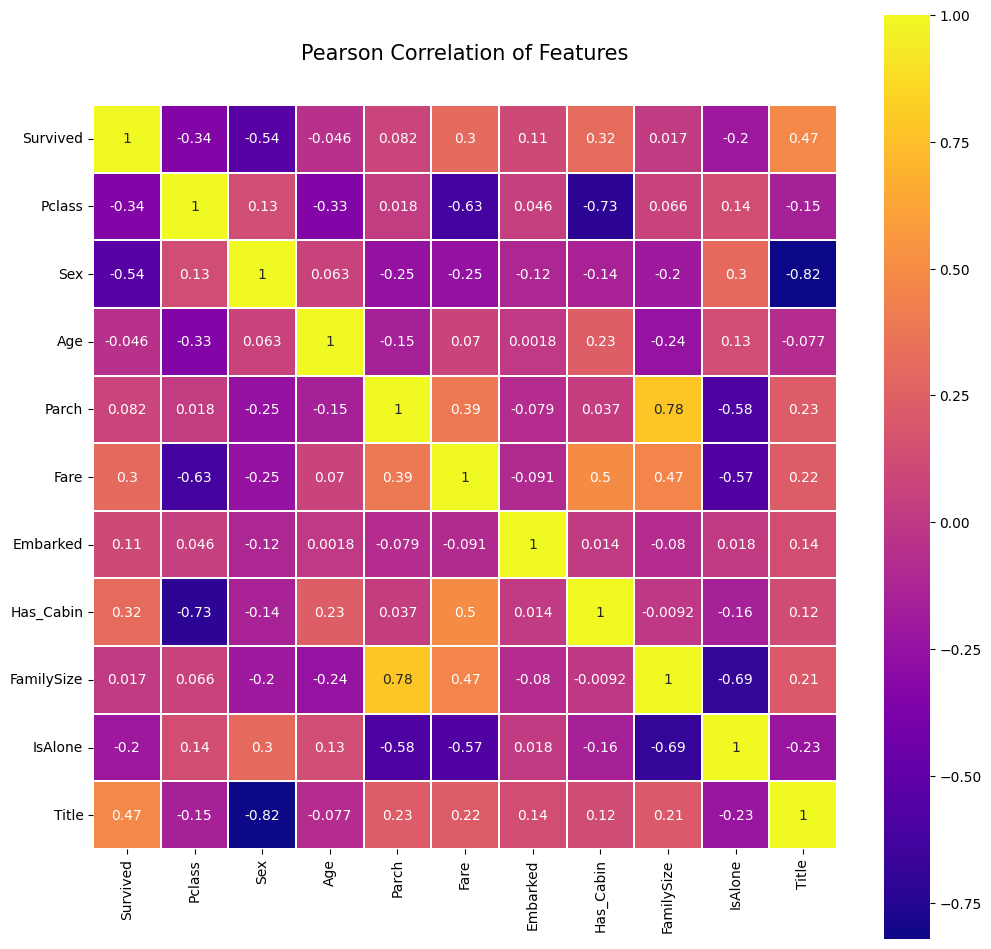

In [1222]:
colormap = plt.colormaps['plasma']
plt.figure(figsize=(12, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white',
            annot=True)

In [1223]:
x = train.copy()
x.drop("Survived", axis=1, inplace=True)
y = train["Survived"]

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, random_state=0)

x_train.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
105,3,1,1,0,0,0,0,1,1,1.0
68,3,0,1,2,1,0,0,7,0,4.0
253,3,1,1,0,2,0,0,2,0,1.0
320,3,1,1,0,0,0,0,1,1,1.0
706,2,0,2,0,1,0,0,1,1,3.0


# Decision Tree

In [1224]:
decision_tree = DecisionTree(min_samples_leaf=1, min_samples_split=0, feature_names=x.columns.values)
decision_tree.fit(x_train, y_train)

predicted_classes = decision_tree.predict(x_test)

accuracy = metrics.accuracy_score(y_test, predicted_classes)
print(f"Decision Tree Accuracy: {accuracy * 100:.2f}%")

Decision Tree Accuracy: 80.27%


# Printing the Decision Tree in a vertical format in the commandline

In [1225]:
decision_tree.print_tree()

                                                                                -> LEAF | Label Counts = 0.0->2, 1.0->20 | Pred Probs = [0.09090909 0.90909091]
                                                                -> NODE | Class: 1.0 | Information Gain = 0.024 | Split IF X[2] < 2.000 THEN left O/W right
                                                                                -> LEAF | Label Counts = 0.0->4, 1.0->14 | Pred Probs = [0.22222222 0.77777778]
                                                -> NODE | Class: 1.0 | Information Gain = 0.056 | Split IF X[3] < 1.000 THEN left O/W right
                                                                                -> LEAF | Label Counts = 1.0->1 | Pred Probs = [0. 1.]
                                                                -> NODE | Class: 1.0 | Information Gain = 0.000 | Split IF X[0] < 2.000 THEN left O/W right
                                                                                -> LEAF | Lab

# Plotting the custom built Decision Tree
### The logic to plot the tree is custom and not taken from any prebuilt libraries
The above step was not effective in visualizing the tree. Given below is the visualization of the tree using a custom plotting function.

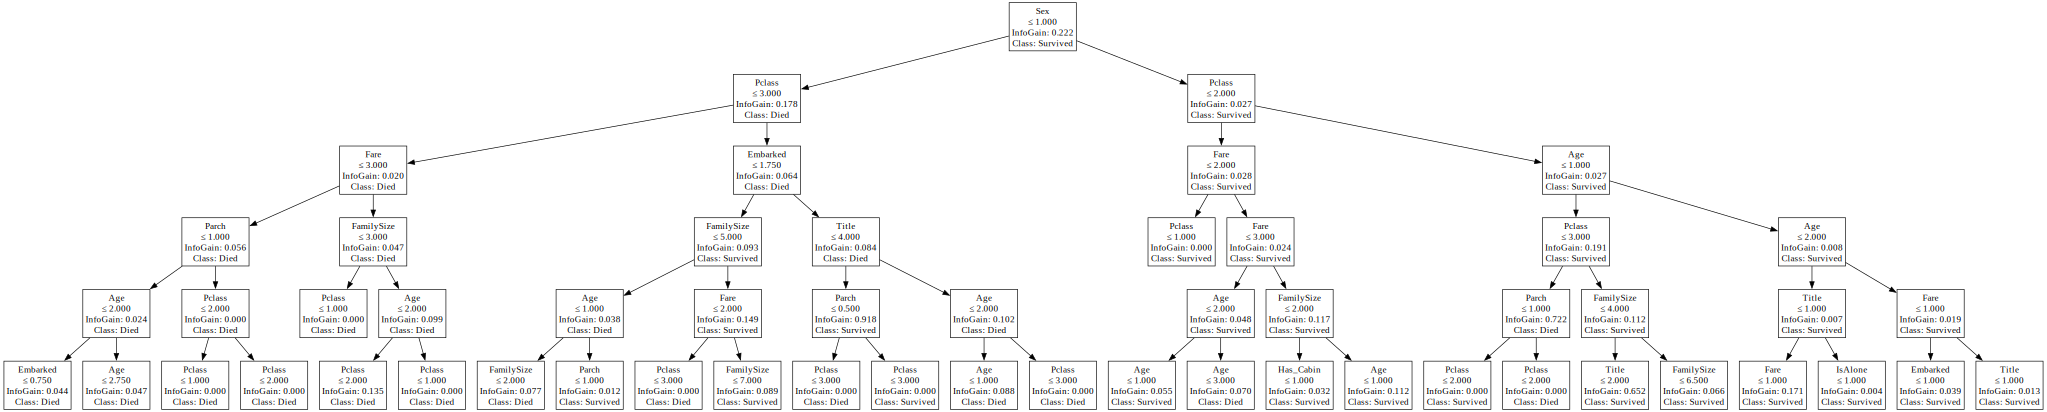

In [1226]:
decision_tree.visualize_tree()

# Random Forest

For this assignment, the conditions for fitting a random forest have been successfully met. Specifically:

1. **Sampling with Replacement**:
   - A random subset of the data has been selected for each tree using sampling with replacement. This means that for each tree, a different subset of the original dataset is used, ensuring diversity among the trees in the forest. For example, a random selection of 5 samples from the dataset `[1, 2, 3, 4, 5]` might result in `[1, 1, 2, 4, 5]`.

2. **Selecting Features**:
   - For each tree, a random subset of features is selected within the range of `[min_features, num_features]`. This is done by generating a list of indices specifying which feature columns to use when training the tree. Each tree in the forest uses a different set of features. For instance, if there are 10 features and `min_features` is set to 6, a random list of indices (e.g., `[0, 1, 3, 6, 7, 8, 9]`) will be used to select the features for each tree. A different list is generated for each tree, ensuring that each tree is trained on a unique subset of features.

Thus, both techniques—sampling with replacement and selecting random features—have been applied when training each tree, ensuring the random forest model leverages the power of diversity and randomness to improve performance.

# RandomForest Class Implementation Summary

In this implementation, a custom `RandomForest` class was created to build a random forest model, using a collection of decision trees with enhanced randomization techniques. The following components were implemented:

1. **Class Initialization (`__init__`)**:
   - Parameters for the random forest include:
     - `n_trees`: The number of trees in the forest (default is 10).
     - `max_depth`: The maximum depth of each tree (default is 5).
     - `min_samples_leaf`: The minimum number of samples required in each leaf node (default is 1).
     - `min_information_gain`: The minimum information gain required for splits (default is 0.0).
     - `min_features`: The minimum number of features to select for each tree (default is 2).
   - The class stores `n_trees`, `max_depth`, `min_samples_leaf`, `min_information_gain`, and `min_features` for tree construction.

2. **Bootstrap Sampling (`_create_bootstrap_samples`)**:
   - This method generates bootstrap samples (subsets of data selected with replacement) for training each tree in the forest.
   - It creates `n_trees` bootstrap samples for both features (`X`) and labels (`y`).

3. **Feature Selection (`_select_random_features`)**:
   - For each tree, a random subset of features is selected, ensuring diversity among the trees. The number of features selected is randomly chosen between `min_features` and the total number of features in the dataset.

4. **Model Training (`fit`)**:
   - The `fit` method:
     - Creates bootstrap samples.
     - For each tree, it selects a random subset of features and trains a decision tree on the corresponding subset of data.
     - It uses a custom `DecisionTree` class to fit the tree to the data with the specified parameters (max depth, min samples per leaf, min information gain).

5. **Prediction (`predict`)**:
   - The `predict` method:
     - For each test sample, it predicts the class label by collecting predictions from all trees.
     - It performs majority voting across all trees to determine the final predicted class for each test instance.

Overall, this implementation of the `RandomForest` class includes features like bootstrap sampling and random feature selection, which are key components of random forests. These techniques help improve model performance by ensuring diversity and reducing overfitting across the decision trees.



In [1227]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, random_state=0)

# Initialize and train RandomForest
rf = RandomForest(n_trees=25, min_features=4)
rf.fit(x_train, y_train)

# Make predictions
y_pred = rf.predict(x_test)

# Evaluate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

Random Forest Accuracy: 82.51%


# AdaBoost Class Implementation Summary

This implementation defines a custom `AdaBoost` class, which combines multiple weak learners (e.g., decision trees) to form a strong classifier. AdaBoost (Adaptive Boosting) works by adjusting the weights of incorrectly classified samples and iteratively training weak classifiers. The following components were implemented:

1. **Class Initialization (`__init__`)**:
   - Parameters:
     - `weak_learner`: The base learner used for boosting, defaulting to a `DecisionTree` with `max_depth=1`.
     - `num_learners`: The number of weak learners (trees) in the ensemble.
     - `learning_rate`: Controls the step size for weight updates.
   - The class maintains a list of `learners` (weak classifiers) and their associated `alphas` (weights).

2. **Error to Weight Conversion (`_calculate_amount_of_say`)**:
   - This method calculates the weight (alpha) for a weak learner based on its classification error. The alpha value determines the learner's influence on the final prediction.
   - The formula for alpha incorporates the error of the learner and the number of unique labels in the dataset.

3. **Sample Weight Update (`_update_weights`)**:
   - This method updates the sample weights after each weak learner is trained.
   - The weight of incorrectly classified samples is increased, making them more influential in the next round of training.
   - The sample weights are normalized after each update.

4. **Model Training (`fit`)**:
   - In the `fit` method, the model iterates over a predefined number of learners (`num_learners`):
     - Bootstrap sampling is performed, selecting a subset of data with replacement.
     - A weak learner is trained on the sampled data.
     - The learner’s error is calculated, and its alpha weight is determined.
     - The sample weights are updated based on the learner's performance.
     - The weak learner and its alpha value are stored for later use in predictions.

5. **Class Probability Prediction (`predict_probabilities`)**:
   - This method calculates the class probabilities by aggregating the predictions from all weak learners.
   - The probabilities from each learner are weighted by their corresponding alpha values and normalized.

6. **Class Label Prediction (`predict`)**:
   - The `predict` method uses the class probabilities to determine the predicted class label for each sample.
   - It returns the class with the highest probability.

### Key Features:
- **Boosting Process**: Iteratively improves model performance by focusing on incorrectly classified samples.
- **Sample Weighting**: Incorrectly classified samples are given more weight in subsequent iterations to improve classification accuracy.
- **Weak Learners**: Typically decision trees with limited depth (`max_depth=1`), which are boosted into a strong classifier.
- **Majority Voting**: Final predictions are made based on the weighted votes of all learners.

This implementation of AdaBoost builds an ensemble of weak classifiers and combines their predictions to form a stronger classifier, improving accuracy by focusing on the hardest-to-classify instances.


In [1228]:
ada_boost = AdaBoost(num_learners=60, learning_rate=0.1)
ada_boost.fit(x_train, y_train)

predicted_classes = ada_boost.predict(x_test)

accuracy = metrics.accuracy_score(y_test, predicted_classes)

print(f"ADA Boost Accuracy: {accuracy * 100:.2f}%")

ADA Boost Accuracy: 82.96%
